# Машинное обучение, ВМК МГУ

## Практическое задание 4. Разложение ошибки на смещение и разброс. Градиентный бустинг ~~своими руками~~

## Часть 1. Bias-Variance Decomposition

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, make_scorer
import math
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from numba import jit

In [2]:
boston = load_boston()

In [3]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

In [6]:
X

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

### Вычисление bias и variance с помощью бутстрапа

#### Задание 1. (1.5 баллa)

In [13]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """

    np.random.seed(1080)
    res = np.full((num_runs, X.shape[0]), np.nan, dtype=np.float64)
    for i in range(num_runs):
        index_train = np.random.choice(X.shape[0], X.shape[0], replace=True)
        index_pred = np.delete(np.arange(X.shape[0]), np.unique(index_train))
        regressor.fit(X[index_train], y[index_train])
        res[i, index_pred] = regressor.predict(X[index_pred])

    bias = np.nanmean((np.nanmean(res, axis=0) - y) ** 2)
    variance = np.nanmean(np.nanmean((res - np.nanmean(res, axis=0)) ** 2, axis=0))
    error = np.nanmean(np.nanmean((y - res) ** 2, axis=0))
    return bias, variance, error

#### Задание 2. (0.5 баллa)

In [28]:
ridge = Ridge()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor(n_jobs=16)

In [15]:
compute_biase_variance(ridge, X, y, num_runs=1000)

(23.906872600732505, 0.8954718808211041, 24.802344481553604)

In [16]:
compute_biase_variance(dt, X, y, num_runs=1000)

(10.179049511981528, 13.033246173909381, 23.212295685890897)

In [21]:
compute_biase_variance(rf, X, y, num_runs=1000)

(10.599619235312826, 2.253989717303973, 12.853608952616794)

Да, согласуются.
У линейной регрессии большое смещение и маленький разброс, потому что это очень простая модель, да еще и с регуляризацией, следовательно она не склонна к переобучению.
У решающего дерева смещение меньше, а разброс сильно больше, потому что этот алгоритм хорошо подгоняется под данные. Судя по такому большому разбросу, дерево переобучается на этих данных.
Random forest это бэггинг над решающими деревьями, поэтому смещение такое же как и у одного дерева. В бэггинг надо брать базовые модели помощнее, что бы смещение было меньше. А разброс получается сильно меньше. В теории бэггинг уменьшает разброс в N раз, где N это количество базовых моделей. В экспериментах это не выполняется, так как базовые модели сильно скоррелированы из-за того, что выборки сгенерированные бутстрапом имеют много общих объектов.

### Визуализация предсказаний базовых алгоритмов бэггинга

#### Задание 3. (1.5 балла)

In [52]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """

    np.random.seed(1080)
    index_test = np.random.choice(X.shape[0], num_test_objects, replace=False)
    index_train = np.delete(np.arange(X.shape[0]), index_test)
    X_test, y_test = X[index_test], y[index_test]
    X_train, y_train = X[index_train], y[index_train]
    for i in range(num_runs):
        bootstrap_index = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
        regressor.fit(X_train[bootstrap_index], y_train[bootstrap_index])
        res = regressor.predict(X_test)
        if i == num_runs - 1:
            plt.scatter(np.arange(num_test_objects), res, color='red', label='Предсказания моделей', s=20)
        else:
            plt.scatter(np.arange(num_test_objects), res, color='red', s=20)
    plt.scatter(np.arange(num_test_objects), y_test, color='black', label='Правильный ответ', s=30)
    plt.xlabel('Объекты тестовой выборки', fontsize=15)
    plt.ylabel('Целевая переменная объектов', fontsize=15)
    plt.xticks(np.arange(num_test_objects))
    plt.xlim([-1, 10])
    plt.ylim([0, 55])
    plt.yticks(np.arange(0, 60, 5))
    plt.title(title, fontsize=18)
    plt.legend()
    plt.grid()

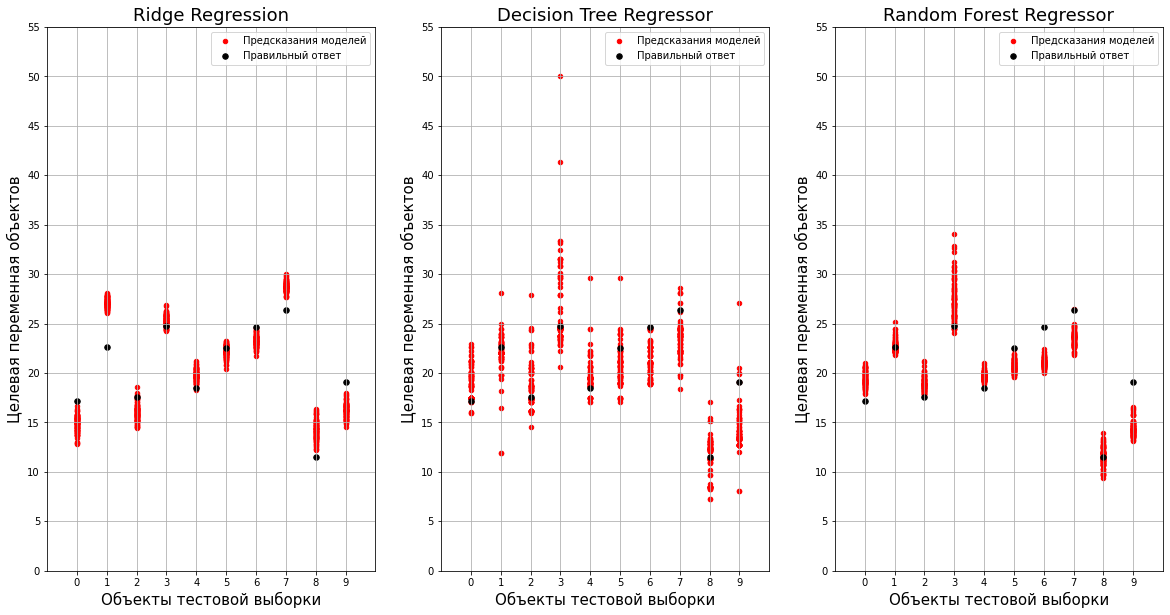

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
plt.subplot(131)
plot_predictions(ridge, X, y, title='Ridge Regression')
plt.subplot(132)
plot_predictions(dt, X, y, title='Decision Tree Regressor')
plt.subplot(133)
plot_predictions(rf, X, y, title='Random Forest Regressor')
plt.show()

По графику для линейной регрессии видно, что разброс алгоритма очень маленький, так как ответы сгруппированы близко друг к другу, но смещение достаточно большое, так как они в среднем лежат далеко от правильного ответа. Особенно большое смещение у линейной регрессии для первого объекта.

У решающего дерева видно, что смещение не такое большое как у линейной регрессии, зато разброс намного больше.

По графику для случайного леса видно, что смещение примерно такое же как и у решающего дерева -- небольшое, а вот разброс сильно меньше.

## Часть 2. Градиентный бустинг

#### Задание 4 (1 балл)

In [2]:
data = pd.read_csv('application_train.csv', index_col='SK_ID_CURR')

In [3]:
data

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239009,0,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,675000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
399937,0,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,472500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
253016,0,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,1125000.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0


In [4]:
y = data[['TARGET']]

In [5]:
X = data.drop(columns='TARGET')

In [6]:
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
247330,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
425716,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
331625,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
455397,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
449114,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239009,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,675000.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
399937,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,472500.0,"Spouse, partner",...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
253016,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,3.0


In [7]:
X.dtypes

NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 120, dtype: object

In [8]:
X.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=120)

In [9]:
for name, dtype in zip(X.columns, X.dtypes):
    if X[name].isna().any():
        if dtype == np.float64:
            X[name] = X[name].fillna(value=np.nanmean(X[name]))
        else:
            vals = np.unique(X[name].dropna(), return_counts=True)
            X[name] = X[name].fillna(value=vals[0][np.argmax(vals[1])])

In [10]:
X

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
247330,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,679500.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
425716,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,450000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
331625,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,675000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,1.000000
455397,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,180000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,2.000000
449114,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,630000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239009,Cash loans,F,N,Y,0,121500.0,675000.0,32602.5,675000.0,Unaccompanied,...,0,0,0,0,0.006416,0.006647,0.03426,0.267319,0.26603,1.899429
399937,Cash loans,F,N,N,2,225000.0,509922.0,40419.0,472500.0,"Spouse, partner",...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,1.00000,4.000000
253016,Cash loans,M,Y,Y,0,450000.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,2.000000,0.00000,3.000000


In [11]:
X.isna().any().any()

False

In [12]:
(y == 1).sum() / y.shape[0]

TARGET    0.080889
dtype: float64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [14]:
X_train.shape

(150679, 120)

In [15]:
float_features = X_train.columns[X_train.dtypes == np.float64]

In [16]:
float_features.shape

(65,)

In [17]:
X_train_float = X_train[float_features].values
X_test_float = X_test[float_features].values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [18]:
filter_fun = []
max_index = []
for i in range(65):
    fea = X_train_float[:, i]
    filter_fun.append(math.fabs(np.mean(fea[y_train == 1]) - np.mean(fea[y_train == 0])) / math.sqrt((np.sum(y_train == 1) * np.var(fea[y_train == 1]) + np.sum(y_train == 0) * np.var(fea[y_train == 0])) / y_train.shape[0]))
filter_fun = np.array(filter_fun)
for i in range(60):
    max_index.append(np.argmax(filter_fun))
    filter_fun[max_index[-1]] = -1
X_train_float = X_train_float[:, max_index]
X_test_float = X_test_float[:, max_index]

С помощью метода фильтрации было оставлено 60 вещественных признаков из 65. Удаление плохих признаков позволило немного поднять качество.

#### Задание 5 (1 балл)

In [54]:
lgb = LGBMClassifier()
ctb = CatBoostClassifier()

In [55]:
%%time

lgb.fit(X_train_float, y_train)

Wall time: 622 ms


LGBMClassifier()

In [56]:
%%time

ctb.fit(X_train_float, y_train)

Learning rate set to 0.087693
0:	learn: 0.6091443	total: 16.2ms	remaining: 16.2s
1:	learn: 0.5365100	total: 32.2ms	remaining: 16.1s
2:	learn: 0.4819024	total: 48.2ms	remaining: 16s
3:	learn: 0.4402781	total: 63.6ms	remaining: 15.8s
4:	learn: 0.4055787	total: 79.4ms	remaining: 15.8s
5:	learn: 0.3776752	total: 94.7ms	remaining: 15.7s
6:	learn: 0.3543444	total: 110ms	remaining: 15.6s
7:	learn: 0.3361893	total: 126ms	remaining: 15.7s
8:	learn: 0.3216850	total: 142ms	remaining: 15.7s
9:	learn: 0.3100495	total: 158ms	remaining: 15.7s
10:	learn: 0.3015909	total: 174ms	remaining: 15.6s
11:	learn: 0.2934443	total: 191ms	remaining: 15.7s
12:	learn: 0.2867931	total: 206ms	remaining: 15.7s
13:	learn: 0.2817419	total: 222ms	remaining: 15.6s
14:	learn: 0.2778060	total: 237ms	remaining: 15.6s
15:	learn: 0.2744210	total: 253ms	remaining: 15.5s
16:	learn: 0.2717977	total: 268ms	remaining: 15.5s
17:	learn: 0.2691979	total: 284ms	remaining: 15.5s
18:	learn: 0.2666237	total: 299ms	remaining: 15.4s
19:	lea

166:	learn: 0.2449188	total: 2.77s	remaining: 13.8s
167:	learn: 0.2448904	total: 2.78s	remaining: 13.8s
168:	learn: 0.2448291	total: 2.8s	remaining: 13.8s
169:	learn: 0.2447984	total: 2.81s	remaining: 13.7s
170:	learn: 0.2447489	total: 2.83s	remaining: 13.7s
171:	learn: 0.2447015	total: 2.85s	remaining: 13.7s
172:	learn: 0.2446319	total: 2.86s	remaining: 13.7s
173:	learn: 0.2445669	total: 2.88s	remaining: 13.7s
174:	learn: 0.2445438	total: 2.89s	remaining: 13.6s
175:	learn: 0.2444940	total: 2.91s	remaining: 13.6s
176:	learn: 0.2444422	total: 2.93s	remaining: 13.6s
177:	learn: 0.2443969	total: 2.94s	remaining: 13.6s
178:	learn: 0.2443218	total: 2.96s	remaining: 13.6s
179:	learn: 0.2442614	total: 2.98s	remaining: 13.6s
180:	learn: 0.2442218	total: 2.99s	remaining: 13.5s
181:	learn: 0.2441590	total: 3.01s	remaining: 13.5s
182:	learn: 0.2441027	total: 3.02s	remaining: 13.5s
183:	learn: 0.2440493	total: 3.04s	remaining: 13.5s
184:	learn: 0.2439921	total: 3.06s	remaining: 13.5s
185:	learn: 0

329:	learn: 0.2377196	total: 5.34s	remaining: 10.9s
330:	learn: 0.2376859	total: 5.36s	remaining: 10.8s
331:	learn: 0.2376389	total: 5.38s	remaining: 10.8s
332:	learn: 0.2375960	total: 5.39s	remaining: 10.8s
333:	learn: 0.2375599	total: 5.41s	remaining: 10.8s
334:	learn: 0.2375042	total: 5.42s	remaining: 10.8s
335:	learn: 0.2374699	total: 5.44s	remaining: 10.8s
336:	learn: 0.2374443	total: 5.46s	remaining: 10.7s
337:	learn: 0.2374089	total: 5.47s	remaining: 10.7s
338:	learn: 0.2373763	total: 5.49s	remaining: 10.7s
339:	learn: 0.2373306	total: 5.5s	remaining: 10.7s
340:	learn: 0.2372972	total: 5.52s	remaining: 10.7s
341:	learn: 0.2372702	total: 5.54s	remaining: 10.7s
342:	learn: 0.2372257	total: 5.55s	remaining: 10.6s
343:	learn: 0.2371904	total: 5.57s	remaining: 10.6s
344:	learn: 0.2371642	total: 5.59s	remaining: 10.6s
345:	learn: 0.2371349	total: 5.6s	remaining: 10.6s
346:	learn: 0.2370774	total: 5.62s	remaining: 10.6s
347:	learn: 0.2370562	total: 5.63s	remaining: 10.6s
348:	learn: 0.

494:	learn: 0.2318740	total: 7.94s	remaining: 8.1s
495:	learn: 0.2318481	total: 7.95s	remaining: 8.08s
496:	learn: 0.2317972	total: 7.97s	remaining: 8.07s
497:	learn: 0.2317615	total: 7.99s	remaining: 8.05s
498:	learn: 0.2317253	total: 8s	remaining: 8.03s
499:	learn: 0.2316757	total: 8.02s	remaining: 8.02s
500:	learn: 0.2316453	total: 8.04s	remaining: 8s
501:	learn: 0.2315976	total: 8.05s	remaining: 7.99s
502:	learn: 0.2315599	total: 8.07s	remaining: 7.97s
503:	learn: 0.2315208	total: 8.08s	remaining: 7.96s
504:	learn: 0.2314924	total: 8.1s	remaining: 7.94s
505:	learn: 0.2314715	total: 8.12s	remaining: 7.92s
506:	learn: 0.2314380	total: 8.13s	remaining: 7.91s
507:	learn: 0.2313886	total: 8.15s	remaining: 7.89s
508:	learn: 0.2313593	total: 8.16s	remaining: 7.87s
509:	learn: 0.2313194	total: 8.18s	remaining: 7.86s
510:	learn: 0.2312787	total: 8.19s	remaining: 7.84s
511:	learn: 0.2312519	total: 8.21s	remaining: 7.82s
512:	learn: 0.2312243	total: 8.22s	remaining: 7.8s
513:	learn: 0.2311852

658:	learn: 0.2266679	total: 10.5s	remaining: 5.44s
659:	learn: 0.2266496	total: 10.5s	remaining: 5.42s
660:	learn: 0.2266079	total: 10.5s	remaining: 5.41s
661:	learn: 0.2265636	total: 10.6s	remaining: 5.39s
662:	learn: 0.2265340	total: 10.6s	remaining: 5.38s
663:	learn: 0.2264932	total: 10.6s	remaining: 5.36s
664:	learn: 0.2264512	total: 10.6s	remaining: 5.34s
665:	learn: 0.2263993	total: 10.6s	remaining: 5.33s
666:	learn: 0.2263795	total: 10.6s	remaining: 5.31s
667:	learn: 0.2263459	total: 10.7s	remaining: 5.3s
668:	learn: 0.2263219	total: 10.7s	remaining: 5.28s
669:	learn: 0.2263027	total: 10.7s	remaining: 5.26s
670:	learn: 0.2262845	total: 10.7s	remaining: 5.25s
671:	learn: 0.2262783	total: 10.7s	remaining: 5.23s
672:	learn: 0.2262395	total: 10.7s	remaining: 5.21s
673:	learn: 0.2262178	total: 10.7s	remaining: 5.2s
674:	learn: 0.2261955	total: 10.8s	remaining: 5.18s
675:	learn: 0.2261622	total: 10.8s	remaining: 5.17s
676:	learn: 0.2261317	total: 10.8s	remaining: 5.15s
677:	learn: 0.

821:	learn: 0.2217530	total: 13.1s	remaining: 2.84s
822:	learn: 0.2217456	total: 13.1s	remaining: 2.82s
823:	learn: 0.2217163	total: 13.1s	remaining: 2.81s
824:	learn: 0.2216859	total: 13.2s	remaining: 2.79s
825:	learn: 0.2216558	total: 13.2s	remaining: 2.77s
826:	learn: 0.2216244	total: 13.2s	remaining: 2.76s
827:	learn: 0.2215897	total: 13.2s	remaining: 2.74s
828:	learn: 0.2215521	total: 13.2s	remaining: 2.73s
829:	learn: 0.2215354	total: 13.2s	remaining: 2.71s
830:	learn: 0.2215216	total: 13.2s	remaining: 2.69s
831:	learn: 0.2215003	total: 13.3s	remaining: 2.68s
832:	learn: 0.2214634	total: 13.3s	remaining: 2.66s
833:	learn: 0.2214286	total: 13.3s	remaining: 2.65s
834:	learn: 0.2213848	total: 13.3s	remaining: 2.63s
835:	learn: 0.2213529	total: 13.3s	remaining: 2.61s
836:	learn: 0.2213358	total: 13.3s	remaining: 2.6s
837:	learn: 0.2213012	total: 13.4s	remaining: 2.58s
838:	learn: 0.2212905	total: 13.4s	remaining: 2.56s
839:	learn: 0.2212759	total: 13.4s	remaining: 2.55s
840:	learn: 0

985:	learn: 0.2171174	total: 15.7s	remaining: 223ms
986:	learn: 0.2170857	total: 15.7s	remaining: 207ms
987:	learn: 0.2170705	total: 15.7s	remaining: 191ms
988:	learn: 0.2170509	total: 15.8s	remaining: 175ms
989:	learn: 0.2170325	total: 15.8s	remaining: 159ms
990:	learn: 0.2170026	total: 15.8s	remaining: 143ms
991:	learn: 0.2169880	total: 15.8s	remaining: 127ms
992:	learn: 0.2169555	total: 15.8s	remaining: 112ms
993:	learn: 0.2169432	total: 15.8s	remaining: 95.6ms
994:	learn: 0.2169133	total: 15.9s	remaining: 79.7ms
995:	learn: 0.2168723	total: 15.9s	remaining: 63.7ms
996:	learn: 0.2168590	total: 15.9s	remaining: 47.8ms
997:	learn: 0.2168453	total: 15.9s	remaining: 31.9ms
998:	learn: 0.2168231	total: 15.9s	remaining: 15.9ms
999:	learn: 0.2168044	total: 15.9s	remaining: 0us
Wall time: 16.3 s


In [57]:
res = lgb.predict_proba(X_test_float)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#LightGBM PR-AUC score

0.2196441154483901

In [58]:
res = ctb.predict_proba(X_test_float)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#CatBoost PR-AUC score

0.22134900299840826

Разница в качестве небольшая, зато LightGBM обучился в 26 раз быстрее. Такая разница в скорости, потому что LightGBM считает градиенты не для всех объектов из обучающей выборки, тем самым ускоряя работу. Так же LightGBM может уменьшать количество признаков, объединяя их. Возможно, CatBoost работает сильно дольше LightGBM еще из-за подсчета несмещенных градиентов, так как для каждого объекта из обучающей выборки надо иметь ансамбль, обученный без этого объекта.
Так же по умолчанию у LightGBM n_estimators=100, а у CatBoost n_estimators=1000.

#### Задание 6. (2 балла)

In [58]:
num_leaves_arr = [x for x in range(10, 40)]
for num_leaves in num_leaves_arr:
    lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=num_leaves, max_depth=-1, learning_rate=0.009, n_estimators=500, 
                         subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, 
                         min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                         reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, silent=True, importance_type='split')
    lgb.fit(X_train_float, y_train)
    res = lgb.predict_proba(X_test_float)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, res)
    print(f'num_leaves = {num_leaves}, PR-AUC =', auc(recall, precision))
    
# num_leaves = 27

num_leaves = 10, PR-AUC = 0.21916134616345645
num_leaves = 11, PR-AUC = 0.21957175948461616
num_leaves = 12, PR-AUC = 0.21979017729360745
num_leaves = 13, PR-AUC = 0.22011862656806808
num_leaves = 14, PR-AUC = 0.2202392595987412
num_leaves = 15, PR-AUC = 0.22088421213957743
num_leaves = 16, PR-AUC = 0.2207672803300728
num_leaves = 17, PR-AUC = 0.22090328390506347
num_leaves = 18, PR-AUC = 0.22106905730332574
num_leaves = 19, PR-AUC = 0.22116700279822243
num_leaves = 20, PR-AUC = 0.22128953278443897
num_leaves = 21, PR-AUC = 0.22168447328811014
num_leaves = 22, PR-AUC = 0.2218411766306545
num_leaves = 23, PR-AUC = 0.22157831419876073
num_leaves = 24, PR-AUC = 0.22181650960052895
num_leaves = 25, PR-AUC = 0.2219106603688797
num_leaves = 26, PR-AUC = 0.2219216916447031
num_leaves = 27, PR-AUC = 0.22240827487872905
num_leaves = 28, PR-AUC = 0.22196190219917883
num_leaves = 29, PR-AUC = 0.2220882826758096
num_leaves = 30, PR-AUC = 0.22168447558129858
num_leaves = 31, PR-AUC = 0.222062703847

In [59]:
max_depth_arr = [x for x in range(1, 11)]
for max_depth in max_depth_arr:
    lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=1024, max_depth=max_depth, learning_rate=0.009, n_estimators=500, 
                         subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, 
                         min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                         reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, silent=True, importance_type='split')
    lgb.fit(X_train_float, y_train)
    res = lgb.predict_proba(X_test_float)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, res)
    print(f'max_depth = {max_depth}, PR-AUC =', auc(recall, precision))
    
#max_depth = 7

max_depth = 1, PR-AUC = 0.19297135968806498
max_depth = 2, PR-AUC = 0.20737675551986984
max_depth = 3, PR-AUC = 0.21466551753780733
max_depth = 4, PR-AUC = 0.21906921526747428
max_depth = 5, PR-AUC = 0.22137111191521475
max_depth = 6, PR-AUC = 0.22291292094320234
max_depth = 7, PR-AUC = 0.22333909473186492
max_depth = 8, PR-AUC = 0.2221731826671015
max_depth = 9, PR-AUC = 0.22068292877636841
max_depth = 10, PR-AUC = 0.217240227477368


In [351]:
def pr_auc(y, y_pred):
    precision, recall, thresholds = precision_recall_curve(y, y_pred)
    return auc(recall, precision)

pr_auc = make_scorer(pr_auc, needs_proba=True)

In [133]:
lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.01, n_estimators=500, 
                     subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, 
                     min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                     reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, silent=True, importance_type='split')
params = {'num_leaves': [x for x in range(2, 128, 4)], 'max_depth': [x for x in range(3, 8)]}
grid_search_cv = GridSearchCV(estimator=lgb, param_grid=params, scoring=pr_auc, n_jobs=1, cv=3)

In [134]:
%%time

grid_search_cv.fit(X_train_float, y_train)

Wall time: 12min 27s


GridSearchCV(cv=3,
             estimator=LGBMClassifier(learning_rate=0.01, n_estimators=500,
                                      objective='binary'),
             n_jobs=1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'num_leaves': [2, 6, 10, 14, 18, 22, 26, 30, 34, 38,
                                        42, 46, 50, 54, 58, 62, 66, 70, 74, 78,
                                        82, 86, 90, 94, 98, 102, 106, 110, 114,
                                        118, ...]},
             scoring=make_scorer(pr_auc, needs_proba=True))

In [135]:
grid_search_cv.best_params_

{'max_depth': 7, 'num_leaves': 30}

In [140]:
grid_search_cv.best_score_

0.22327922384224133

In [570]:
lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=30, max_depth=7, learning_rate=0.01, n_estimators=500, 
                     subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, 
                     min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                     reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, silent=True, importance_type='split')

In [571]:
%%time

lgb.fit(X_train_float, y_train)

Wall time: 2.39 s


LGBMClassifier(learning_rate=0.01, max_depth=7, n_estimators=500, num_leaves=30,
               objective='binary')

In [572]:
res = lgb.predict_proba(X_test_float)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#LightGBM PR-AUC score

0.22433838844924728

In [347]:
ctb = CatBoostClassifier(task_type='GPU', devices='NULL', objective='Logloss', iterations=500, learning_rate=0.05, 
                         l2_leaf_reg=3.5, depth=6, grow_policy='SymmetricTree', min_data_in_leaf=1, max_leaves=31, 
                         score_function='Cosine', silent=True)

In [348]:
%%time

ctb.fit(X_train_float, y_train)

Wall time: 3.8 s


In [349]:
res = ctb.predict_proba(X_test_float)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#CatBoost PR-AUC score

0.2286472928240314

In [352]:
ctb = CatBoostClassifier(task_type='GPU', devices='NULL', objective='Logloss', iterations=500, learning_rate=0.05, 
                         l2_leaf_reg=3.5, depth=6, grow_policy='SymmetricTree', min_data_in_leaf=1, max_leaves=31, 
                         score_function='Cosine', silent=True)
params = {'depth': [x for x in range(3, 10)], 'grow_policy': ['SymmetricTree', 'Depthwise'], 'score_function': ['Cosine', 'L2']}
grid_search_cv = GridSearchCV(estimator=ctb, param_grid=params, scoring=pr_auc, n_jobs=1, cv=3)

In [353]:
%%time

grid_search_cv.fit(X_train_float, y_train)

c:\users\илья\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\users\илья\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\users\илья\appdata\local\programs\python\python38\lib\site-packages\catboost\core.py", line 4300, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\users\илья\appdata\local\programs\python\python38\lib\site-packages\catboost\core.py", line 1804, in _fit
    self._train(
  File "c:\users\илья\appdata\local\programs\python\python38\lib\site-packages\catboost\core.py", line 1258, in _train
    self._obj

Wall time: 4min 52s


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002444D15F970>,
             n_jobs=1,
             param_grid={'depth': [3, 4, 5, 6, 7, 8, 9],
                         'grow_policy': ['SymmetricTree', 'Depthwise'],
                         'score_function': ['Cosine', 'L2']},
             scoring=make_scorer(pr_auc, needs_proba=True))

In [354]:
grid_search_cv.best_params_

{'depth': 3, 'grow_policy': 'Depthwise', 'score_function': 'L2'}

In [355]:
grid_search_cv.best_score_

0.2243179680006039

In [492]:
ctb = CatBoostClassifier(task_type='GPU', devices='NULL', objective='Logloss', iterations=1000, learning_rate=0.025, 
                         l2_leaf_reg=2.6, depth=4, grow_policy='Depthwise', min_data_in_leaf=1, max_leaves=31, 
                         score_function='Cosine', silent=True)

In [499]:
%%time

ctb.fit(X_train_float, y_train)

Wall time: 8.54 s


In [500]:
res = ctb.predict_proba(X_test_float)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#CatBoost PR-AUC score

0.2271962103129275

In [564]:
ctb = CatBoostClassifier(task_type='GPU', devices='NULL', objective='Logloss', iterations=1000, learning_rate=0.025, 
                         l2_leaf_reg=2.5, depth=3, grow_policy='Lossguide', min_data_in_leaf=1, max_leaves=31, 
                         score_function='L2', silent=True)

In [565]:
%%time

ctb.fit(X_train_float, y_train)

Wall time: 7.84 s


In [566]:
res = ctb.predict_proba(X_test_float)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#CatBoost PR-AUC score

0.22652011657324023

Для LightGBM сложность деревьев лучше регулировать и максимальной глубиной дерева, и максимальным количеством листьев одновременно, так как узлы разбиваются не по уровням, а по наискорейшей минимизации функции потерь. Оптимальное соотношение для LightGBM: максимальное количество листьев -- 30, максимальная глубина -- 7, количество деревьев -- 500. Подобрав остальные гиперпараметры, удалось достигнуть качества 0.2243 PR-AUC.

Для CatBoost оптимальное соотношение: глубина деревьев -- 4, количество деревьев -- 1000. В СatBoost лучшим вариантом оказалось использование метода построения деревьев Depthwise, эти деревья полные (строятся по уровням полностью), поэтому глубина меньше, чем в LightGBM. Подобрав остальные гиперпараметры, удалось достигнуть качества 0.2272 PR-AUC.

#### Задание 7 (1.5 баллa)

In [19]:
X_train_float.shape

(150679, 60)

In [20]:
X_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
184564,Cash loans,F,N,Y,0,180000.0,601470.0,30838.5,450000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,1.000000,0.00000,3.000000
421909,Cash loans,F,N,Y,0,225000.0,1096020.0,59589.0,900000.0,Unaccompanied,...,0,0,0,0,0.006416,0.006647,0.03426,0.267319,0.26603,1.899429
249245,Cash loans,F,N,Y,0,270000.0,769500.0,24822.0,769500.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,2.000000
109060,Cash loans,M,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
172671,Cash loans,M,Y,Y,2,270000.0,490536.0,38884.5,405000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300120,Cash loans,M,N,N,1,306000.0,1195101.0,65011.5,1129500.0,Family,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000
264476,Cash loans,F,N,Y,0,360000.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,0.000000,0.00000,3.000000
217352,Cash loans,M,N,Y,1,247500.0,818671.5,38065.5,661500.0,Unaccompanied,...,0,0,0,0,0.000000,0.000000,0.00000,1.000000,0.00000,3.000000


In [21]:
X_train_float

array([[0.40312766, 0.72239289, 0.29205121, ..., 0.0356    , 0.        ,
        0.        ],
       [0.565091  , 0.51106997, 0.19477612, ..., 0.0706    , 0.00664671,
        0.26602976],
       [0.62655367, 0.49927202, 0.90318602, ..., 0.06493327, 0.        ,
        0.        ],
       ...,
       [0.71354235, 0.17982177, 0.48651699, ..., 0.06493327, 0.        ,
        0.        ],
       [0.63546867, 0.44539624, 0.50232371, ..., 0.0716    , 0.        ,
        0.        ],
       [0.4213414 , 0.75306739, 0.45500798, ..., 0.06493327, 0.        ,
        0.        ]])

In [22]:
cat_features = X_train.columns[X_train.dtypes == 'object']

In [23]:
cat_features

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [24]:
int_features = X_train.columns[X_train.dtypes == np.int64]

In [25]:
float_features.shape

(65,)

In [26]:
one_hot_enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_one_hot = np.hstack((one_hot_enc.fit_transform(X_train[cat_features].values), X_train[int_features].values, X_train_float))
X_test_one_hot = np.hstack((one_hot_enc.transform(X_test[cat_features].values), X_test[int_features].values, X_test_float))

In [27]:
X_train_one_hot.shape

(150679, 238)

In [112]:
lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=46, max_depth=-1, learning_rate=0.006, n_estimators=1000, 
                     subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, 
                     min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                     reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split')

In [113]:
%%time

lgb.fit(X_train_one_hot, y_train)

Wall time: 7.37 s


LGBMClassifier(learning_rate=0.006, n_estimators=1000, num_leaves=46,
               objective='binary')

In [114]:
res = lgb.predict_proba(X_test_one_hot)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#LightGBM PR-AUC score

0.2363874434257618

In [30]:
ctb = CatBoostClassifier(task_type='GPU', devices='NULL', objective='Logloss', iterations=1200, learning_rate=0.02, 
                         l2_leaf_reg=3.0, depth=4, grow_policy='Depthwise', min_data_in_leaf=1, max_leaves=31, 
                         score_function='Cosine', silent=True)

In [31]:
%%time

ctb.fit(X_train_one_hot, y_train)

Wall time: 12.2 s


In [152]:
res = ctb.predict_proba(X_test_one_hot)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#CatBoost PR-AUC score

0.24057426247785862

In [42]:
@jit(nopython=True)
def kfold(n, n_folds):
    index_list = []
    d = n // n_folds
    for i in range(n_folds - 1):
        arr_val = np.arange(i * d, (i + 1) * d)
        arr_train = np.hstack((np.arange(0, i * d), np.arange((i + 1) * d, n)))
        index_list.append((arr_train, arr_val))
    index_list.append((np.arange((n_folds - 1) * d), np.arange((n_folds - 1) * d, n)))
    return index_list


def counters(x_train, y_train, x_test, cat_features, num_folds=None, timing=False):
    if timing:
        for feature in cat_features:
            x_train[feature], x_test[feature] = counters_maker_timing(x_train[feature].to_numpy().flatten(),
                                                                      x_test[feature].to_numpy().flatten(),
                                                                      y_train)
    else:
        prior = np.mean(y_train)
        if num_folds is None:
            for feature in cat_features:
                x_train[feature], x_test[feature] = counters_maker(x_train[feature].to_numpy().flatten(),
                                                                   x_test[feature].to_numpy().flatten(),
                                                                   y_train, prior=prior)
        else:
            for feature in cat_features:
                x_train[feature], x_test[feature] = counters_maker_folding(x_train[feature].to_numpy().flatten(),
                                                                           x_test[feature].to_numpy().flatten(),
                                                                           y_train, num_folds, prior=prior)


def counters_maker(x_train_feature, x_test_feature, target, prior=0.5, c=10.0):
    categories, counts = np.unique(x_train_feature, return_counts=True)
    categories_cond, counts_cond = np.unique(x_train_feature[target == 1], return_counts=True)
    categories_test = np.unique(x_test_feature)
    x_train_res, x_test_res = np.empty(x_train_feature.shape[0], dtype=np.float64), \
                              np.full(x_test_feature.shape[0], -1, dtype=np.float64)

    for cat in categories:
        if np.any(categories_cond == cat):
            res = (counts_cond[categories_cond == cat][0] + c * prior) / (counts[categories == cat][0] + c)
            x_train_res[x_train_feature == cat] = res
        else:
            res = c * prior / (counts[categories == cat][0] + c)
            x_train_res[x_train_feature == cat] = res

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    x_test_res[x_test_res == -1.0] = prior
    return x_train_res, x_test_res


def counters_maker_folding(x_train_feature, x_test_feature, target, num_folds, prior=0.5, c=10.0):
    index_list = kfold(x_train_feature.shape[0], num_folds)
    x_test_res = np.full(x_test_feature.shape[0], -1, dtype=np.float64)
    x_train_res = np.array([], dtype=np.float64)
    for index in index_list:
        categories, counts = np.unique(x_train_feature[index[0]], return_counts=True)
        categories_cond, counts_cond = np.unique(x_train_feature[index[0]][target[index[0]] == 1], return_counts=True)
        categories_fold = np.unique(x_train_feature[index[1]])
        x_fold_tmp = np.full(index[1].shape[0], -1, dtype=np.float64)
        for cat in categories:
            if np.any(categories_cond == cat):
                res = (counts_cond[categories_cond == cat][0] + c * prior) / (counts[categories == cat][0] + c)
            else:
                res = c * prior / (counts[categories == cat][0] + c)

            if np.any(categories_fold == cat):
                x_fold_tmp[x_train_feature[index[1]] == cat] = res

        x_fold_tmp[x_fold_tmp == -1.0] = prior
        x_train_res = np.append(x_train_res, x_fold_tmp)

    categories, counts = np.unique(x_train_feature, return_counts=True)
    categories_cond, counts_cond = np.unique(x_train_feature[target == 1], return_counts=True)
    categories_test = np.unique(x_test_feature)
    for cat in categories:
        if np.any(categories_cond == cat):
            res = (counts_cond[categories_cond == cat][0] + c * prior) / (counts[categories == cat][0] + c)
        else:
            res = c * prior / (counts[categories == cat][0] + c)

        if np.any(categories_test == cat):
            x_test_res[x_test_feature == cat] = res

    x_test_res[x_test_res == -1.0] = prior
    return x_train_res, x_test_res


# deprecated
def counters_maker_timing(x_train_feature, x_test_feature, target):
    cat_train = np.unique(x_train_feature)
    x_train_res = np.empty(x_train_feature.shape[0], dtype=np.float64)
    x_train_res[0] = 0.5
    for cat in np.unique(x_test_feature):
        if np.any(cat_train == cat):
            x_test_feature[x_test_feature == cat] = np.sum(target[x_train_feature == cat]) / np.sum(x_train_feature == cat)
        else:
            x_test_feature[x_test_feature == cat] = 0.5
    for i in range(1, x_train_res.shape[0]):
        if np.any(x_train_feature[i] == x_train_feature[0:i]):
            x_train_res[i] = np.sum(target[0:i][x_train_feature[0:i] == x_train_feature[i]]) / np.sum(x_train_feature[0:i] == x_train_feature[i])
        else:
            x_train_res[i] = 0.5
    return x_train_res, x_test_feature

In [59]:
%%time

X_train_cat, X_test_cat = X_train[cat_features].copy(), X_test[cat_features].copy()
counters(X_train_cat, y_train, X_test_cat, cat_features, num_folds=3)

Wall time: 5.14 s


In [60]:
X_train_counter = np.hstack((X_train_cat.values, X_train_float, X_train[int_features].values.astype(np.float64)))
X_test_counter = np.hstack((X_test_cat.values, X_test_float, X_test[int_features].values.astype(np.float64)))

In [61]:
X_train_counter.shape, X_train_counter.dtype

((150679, 115), dtype('float64'))

In [62]:
lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=46, max_depth=-1, learning_rate=0.006, n_estimators=1000, 
                     subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, 
                     min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                     reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split')

In [63]:
%%time

lgb.fit(X_train_counter, y_train)

Wall time: 6.98 s


LGBMClassifier(learning_rate=0.006, n_estimators=1000, num_leaves=46,
               objective='binary')

In [64]:
res = lgb.predict_proba(X_test_counter)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#LightGBM PR-AUC score

0.23707518366365368

In [65]:
ctb = CatBoostClassifier(task_type='GPU', devices='NULL', objective='Logloss', iterations=1200, learning_rate=0.02, 
                         l2_leaf_reg=3.0, depth=4, grow_policy='Depthwise', min_data_in_leaf=1, max_leaves=31, 
                         score_function='Cosine', silent=True)

In [66]:
%%time

ctb.fit(X_train_counter, y_train)

Wall time: 9.83 s


In [67]:
res = ctb.predict_proba(X_test_counter)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#CatBoost PR-AUC score

0.24120057780910886

Для LightGBM на этом датасете время обучения не зависит от того, используется one hot кодирование или кодирование счетчиками, и составляет примерно 7 секунд.
Для CatBoost есть разница во времени обучения между one hot и счетчиками, но она не большая: 12 секунд с one hot и 10 секунд с счетчиками.

При этом качество с счетчиками со сглаживанием и фолдингом выше для обоих алгоритмов LightGBM и CatBoost.

#### Задание 8 (1 балл)

In [138]:
float_features = X_train.columns[X_train.dtypes == np.float64]
X_train_float = X_train[float_features].values
X_test_float = X_test[float_features].values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
filter_fun = []
min_index = []
for i in range(len(float_features)):
    fea = X_train_float[:, i]
    filter_fun.append(math.fabs(np.mean(fea[y_train == 1]) - np.mean(fea[y_train == 0])) / math.sqrt((np.sum(y_train == 1) * np.var(fea[y_train == 1]) + np.sum(y_train == 0) * np.var(fea[y_train == 0])) / y_train.shape[0]))
filter_fun = np.array(filter_fun)
for i in range(5):
    min_index.append(float_features[np.argmin(filter_fun)])
    filter_fun[np.argmin(filter_fun)] = np.inf
X_train = X_train.drop(columns=min_index)
X_test = X_test.drop(columns=min_index)

In [139]:
X_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
184564,Cash loans,F,N,Y,0,180000.0,601470.0,30838.5,450000.0,Unaccompanied,...,0,0,0,0,0,0,0.000000,1.000000,0.00000,3.000000
421909,Cash loans,F,N,Y,0,225000.0,1096020.0,59589.0,900000.0,Unaccompanied,...,0,0,0,0,0,0,0.006647,0.267319,0.26603,1.899429
249245,Cash loans,F,N,Y,0,270000.0,769500.0,24822.0,769500.0,Unaccompanied,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,2.000000
109060,Cash loans,M,N,N,0,112500.0,755190.0,36328.5,675000.0,Unaccompanied,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000
172671,Cash loans,M,Y,Y,2,270000.0,490536.0,38884.5,405000.0,Unaccompanied,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300120,Cash loans,M,N,N,1,306000.0,1195101.0,65011.5,1129500.0,Family,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000
264476,Cash loans,F,N,Y,0,360000.0,1125000.0,33025.5,1125000.0,Unaccompanied,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,3.000000
217352,Cash loans,M,N,Y,1,247500.0,818671.5,38065.5,661500.0,Unaccompanied,...,0,0,0,0,0,0,0.000000,1.000000,0.00000,3.000000


In [140]:
(X_train.dtypes == np.float64).sum()

60

In [95]:
cat_features = X_train.columns[X_train.dtypes == 'object']

In [102]:
ctb = CatBoostClassifier(task_type='GPU', devices='NULL', objective='Logloss', iterations=1200, learning_rate=0.02, 
                         l2_leaf_reg=3.0, depth=4, grow_policy='Depthwise', min_data_in_leaf=1, max_leaves=31, 
                         score_function='Cosine', silent=True, cat_features=cat_features)

In [103]:
%%time

ctb.fit(X_train, y_train)

Wall time: 24.1 s


In [104]:
res = ctb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#CatBoost PR-AUC score

0.24111029366012812

Время обучения CatBoost составило 24 секунды, что на 14 секунд больше чем когда категориальные признаки были предобработаны вручную. Качество по метрике PR-AUC оказалось примерно таким же, как с кодированием счетчиками вручную (гиперпараметры были взяты такие же). Кодирование счетчиками заняло 5 секунд, что намного меньше разницы в 14 секунд.

Очевидно, что время обучения увеличилось из-за необходимости закодировать категориальные признаки.

#### Бонус. (1 балл)

In [143]:
float_features = X_train.columns[X_train.dtypes == np.float64]
cat_features = X_train.columns[X_train.dtypes == 'object']
X_train_float = X_train[float_features].values
X_test_float = X_test[float_features].values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
filter_fun = []
min_index = []
for i in range(len(float_features)):
    fea = X_train_float[:, i]
    filter_fun.append(math.fabs(np.mean(fea[y_train == 1]) - np.mean(fea[y_train == 0])) / math.sqrt((np.sum(y_train == 1) * np.var(fea[y_train == 1]) + np.sum(y_train == 0) * np.var(fea[y_train == 0])) / y_train.shape[0]))
filter_fun = np.array(filter_fun)
for i in range(5):
    min_index.append(float_features[np.argmin(filter_fun)])
    filter_fun[np.argmin(filter_fun)] = np.inf
X_train = X_train.drop(columns=min_index)
X_test = X_test.drop(columns=min_index)
counters(X_train, y_train, X_test, cat_features, num_folds=3)

In [144]:
X_train

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
184564,0.083296,0.068454,0.084788,0.078424,0,180000.0,601470.0,30838.5,450000.0,0.080421,...,0,0,0,0,0,0,0.000000,1.000000,0.00000,3.000000
421909,0.083296,0.068454,0.084788,0.078424,0,225000.0,1096020.0,59589.0,900000.0,0.080421,...,0,0,0,0,0,0,0.006647,0.267319,0.26603,1.899429
249245,0.083296,0.068454,0.084788,0.078424,0,270000.0,769500.0,24822.0,769500.0,0.080421,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,2.000000
109060,0.083296,0.102399,0.084788,0.083760,0,112500.0,755190.0,36328.5,675000.0,0.080421,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000
172671,0.083296,0.102399,0.070930,0.078424,2,270000.0,490536.0,38884.5,405000.0,0.080421,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300120,0.083985,0.101626,0.086244,0.084809,1,306000.0,1195101.0,65011.5,1129500.0,0.076358,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,0.000000
264476,0.083985,0.070609,0.086244,0.079678,0,360000.0,1125000.0,33025.5,1125000.0,0.081921,...,0,0,0,0,0,0,0.000000,0.000000,0.00000,3.000000
217352,0.083985,0.101626,0.086244,0.079678,1,247500.0,818671.5,38065.5,661500.0,0.081921,...,0,0,0,0,0,0,0.000000,1.000000,0.00000,3.000000


In [285]:
lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=49, max_depth=7, learning_rate=0.0059, n_estimators=1300, 
                     subsample_for_bin=200000, objective='binary', class_weight=None, min_split_gain=0.0, 
                     min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, 
                     reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split')

In [286]:
%%time

lgb.fit(X_train, y_train)

Wall time: 8.36 s


LGBMClassifier(learning_rate=0.0059, max_depth=7, n_estimators=1300,
               num_leaves=49, objective='binary')

In [287]:
res = lgb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#LightGBM PR-AUC score

0.23866861837378045

In [15]:
float_features = X_train.columns[X_train.dtypes == np.float64]
cat_features = X_train.columns[X_train.dtypes == 'object']
X_train_float = X_train[float_features].values
X_test_float = X_test[float_features].values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
filter_fun = []
min_index = []
for i in range(len(float_features)):
    fea = X_train_float[:, i]
    filter_fun.append(math.fabs(np.mean(fea[y_train == 1]) - np.mean(fea[y_train == 0])) / math.sqrt((np.sum(y_train == 1) * np.var(fea[y_train == 1]) + np.sum(y_train == 0) * np.var(fea[y_train == 0])) / y_train.shape[0]))
filter_fun = np.array(filter_fun)
for i in range(5):
    min_index.append(float_features[np.argmin(filter_fun)])
    filter_fun[np.argmin(filter_fun)] = np.inf
X_train = X_train.drop(columns=min_index)
X_test = X_test.drop(columns=min_index)

In [112]:
ctb = CatBoostClassifier(task_type='GPU', devices='NULL', objective='Logloss', iterations=1400, learning_rate=0.019, 
                         l2_leaf_reg=2.3, depth=4, grow_policy='Depthwise', min_data_in_leaf=1, max_leaves=31, 
                         score_function='Cosine', silent=True, cat_features=cat_features)

In [113]:
%%time

ctb.fit(X_train, y_train)

Wall time: 26.6 s


In [114]:
res = ctb.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, res)
auc(recall, precision)
#CatBoost PR-AUC score

0.24174324601657507

С точки зрения качества с оптимальными параметрами CatBoost лучше LightGBM: 0.2387 против 0.2417. Но по скорости обучения LightGBM выигрывает достаточно сильно: 8 секунд против 27 секунд и это при том, что CatBoost обучался на достаточно мощной видеокарте (на CPU с такими же параметрами около 80 секунд), а LightGBM обучался на CPU.

Результат примерно совпадает с моими ожиданиями: я верил, что CatBoost лучше LightGBM, осталось только оптимизировать скорость обучения.

#### Бонус (0.2 балла)

In [1]:
from IPython.display import Image

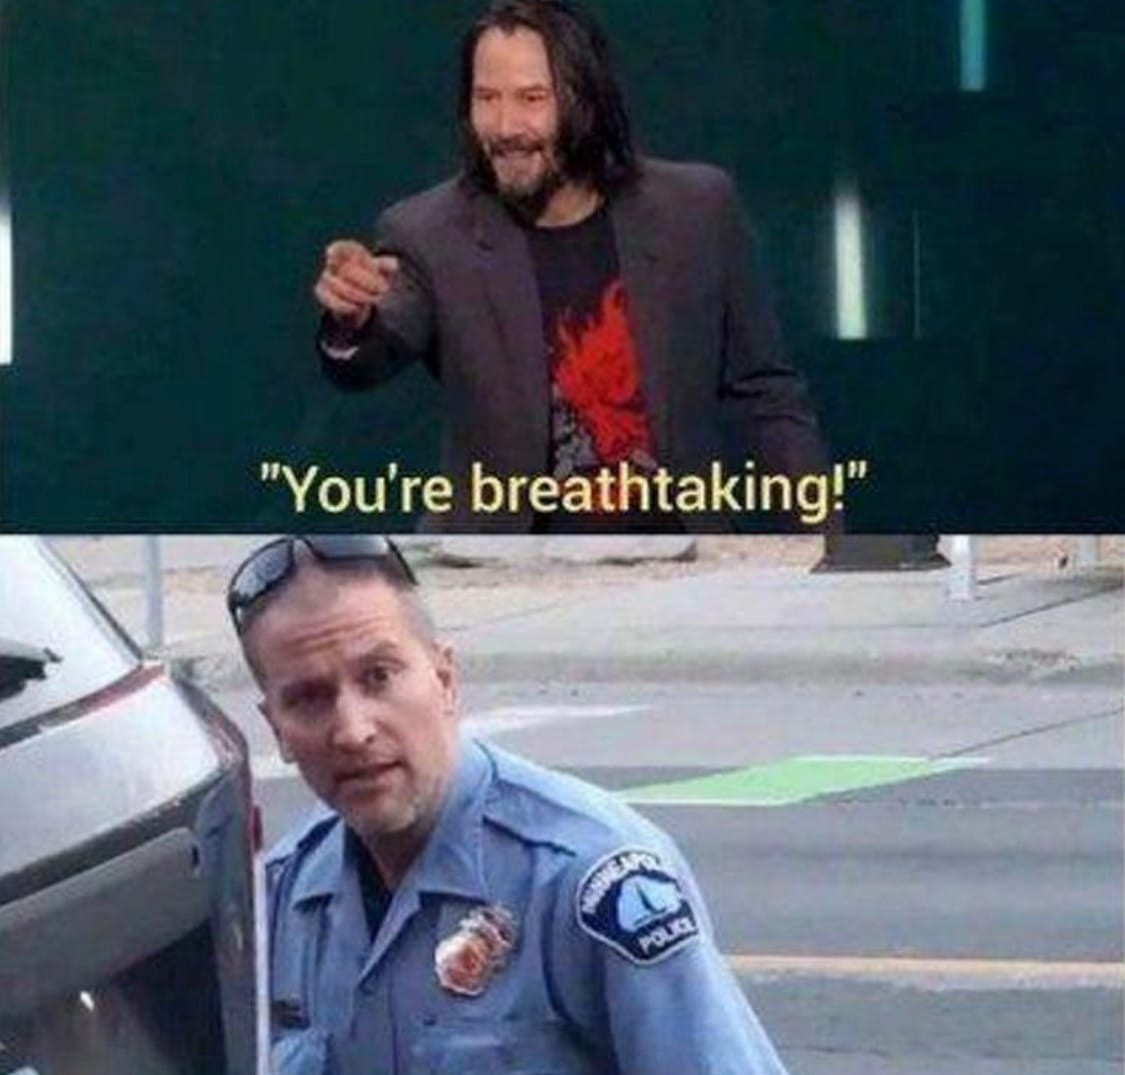

In [2]:
Image(filename='meme.jpg')